In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas


In [2]:
def DaskProfReader(filename):
    filename = open(filename,'r')
    timestamps=list()
    for line in filename:
        for item in line.split():
            if item.startswith('start_time'):
                timestamp1=float(item.split('=')[1].split(',')[0])
            elif item.startswith('end_time'):
                timestamp2=float(item.split('=')[1].split(',')[0])
        timestamps.append([timestamp1,timestamp2])
    
    filename.close()
    
    return np.array(timestamps)
    

In [3]:
def SchedulerDelay(profiles):
    delays = np.array([])
    for profile in profiles:
        start_times = profile[:,0]
        start_times.sort()
        start_times = start_times-start_times[0]
        delays = np.append(delays,start_times[0:-1])
        
    return delays
        

In [4]:
def SchedulerDelayDist(profiles):
    delays = np.array([])
    
    for profile in profiles:
        exec_start = profile[0][0]
        start_times = profile[1][:,0]
        start_times.sort()
        start_times=start_times-exec_start
        delays = np.append(delays,start_times)
    
    return delays

In [5]:
# Dask Distributed
profiles_dist=list()
profiles_dist_32=list()
profiles_dist_48=list()
profiles_dist_64=list()
for i in range(0,10):
    profiles_dist.append(np.load('Stampede/SchedDelays/timings_16_1_%02d.npz.npy'%(i+1)))
    profiles_dist_32.append(np.load('Stampede/SchedDelays/timings_32_%02d.npz.npy'%(i+1)))
    profiles_dist_48.append(np.load('Stampede/SchedDelays/timings_48_%02d.npz.npy'%(i+1)))
    profiles_dist_64.append(np.load('Stampede/SchedDelays/timings_64_%02d.npz.npy'%(i+1)))

In [6]:
# Dask Multiprocessing
profiles_multi=list()

for i in range(0,10):
    profiles_multi.append(DaskProfReader('Stampede/SchedDelays/multiproc_prof%02d'%i))

In [7]:
# Dask Threading
profiles_thread=list()

for i in range(0,10):
    profiles_thread.append(DaskProfReader('Stampede/SchedDelays/threaded_prof%02d'%i))

In [8]:
threadedDelay = SchedulerDelay(profiles_thread)

In [9]:
multiprocDelay = SchedulerDelay(profiles_multi)

In [10]:
distDelay = SchedulerDelayDist(profiles_dist)
distDelay_32 = SchedulerDelayDist(profiles_dist_32)
distDelay_48 = SchedulerDelayDist(profiles_dist_48)
distDelay_64 = SchedulerDelayDist(profiles_dist_64)

In [11]:
distDelay=distDelay.reshape(10,16)
multiprocDelay=multiprocDelay.reshape(10,16)
threadedDelay=threadedDelay.reshape(10,16)
distDelay_32=distDelay_32.reshape(10,32)
distDelay_48=distDelay_48.reshape(10,48)
distDelay_64=distDelay_64.reshape(10,64)

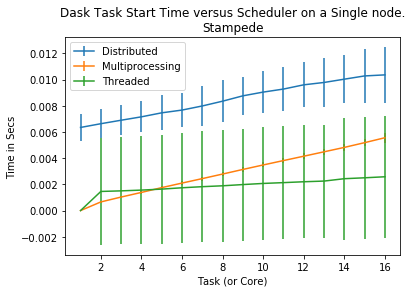

In [14]:
plt.errorbar(range(1,17),distDelay.mean(0),yerr=distDelay.std(0),label='Distributed')
plt.errorbar(range(1,17),multiprocDelay.mean(0),yerr=multiprocDelay.std(0),label='Multiprocessing')
plt.errorbar(range(1,17),threadedDelay.mean(0),yerr=threadedDelay.std(0),label='Threaded')
plt.legend()
plt.title('Dask Task Start Time versus Scheduler on a Single node.\nStampede')
plt.ylabel('Time in Secs')
plt.xlabel('Task (or Core)')
plt.savefig('daskSchedulerDelaysSingleNode.pdf',dpi=800,bbox_inches='tight')
plt.savefig('daskSchedulerDelaysSingleNode.png',dpi=800,bbox_inches='tight')

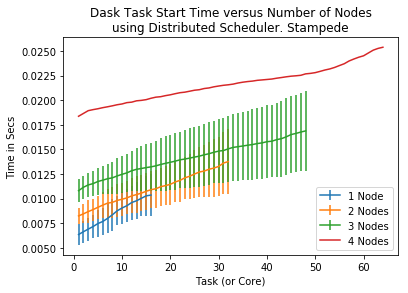

In [15]:
plt.errorbar(range(1,17),distDelay.mean(0),yerr=distDelay.std(0),label='1 Node')
plt.errorbar(range(1,33),distDelay_32.mean(0),yerr=distDelay_32.std(0),label='2 Nodes')
plt.errorbar(range(1,49),distDelay_48.mean(0),yerr=distDelay_48.std(0),label='3 Nodes')
plt.errorbar(range(1,65),distDelay_64.mean(0),label='4 Nodes')
plt.legend()
plt.title('Dask Task Start Time versus Number of Nodes\nusing Distributed Scheduler. Stampede')
plt.ylabel('Time in Secs')
plt.xlabel('Task (or Core)')
plt.savefig('daskSchedulerDelaysvsNodes.pdf',dpi=800,bbox_inches='tight')
plt.savefig('daskSchedulerDelaysvsNodes.png',dpi=800,bbox_inches='tight')

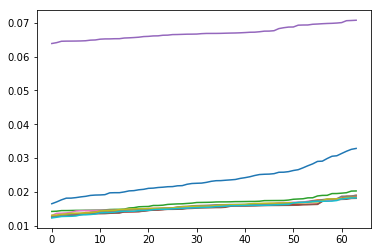

In [149]:
for i in range(0,10):
    plt.plot(distDelay_64[i,:])